## Compare detection and equilibrium times across different host population sizes

In [1]:
import os
import sys
import getopt
import json
from datetime import datetime
import pandas as pd
import numpy as np

from lib.preferences import *
from lib.response import *
from lib.plotting import *

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  # for legend
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.dpi'] = 100

## Settings

In [2]:
genetic_metrics = list(genetic_names.keys())
genetic_names.update(op_names)

In [3]:
output_dir = "../figs/review/analysis_cf-popn-size"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
savefig = True

## Load averaged trajectories of each size

In [4]:
input_dir = "../analysis"
intv = "nv"
focus = "crash"
stat = "equilibrium"

In [5]:
titles = {
    "gamma": "Vary Clearance Rate ($\gamma$)",
    "nv": "Vary No. Vectors ($N_V$)",
    "bite_rate_per_v": "Vary Bite Rate ($b$)"
}

xlabs = {
    "detection" : "Detection Time [Years]",
    "equilibrium" : "Equilibrium Time [Years]"
}

intv_names = {
    "big" : "$N_H=$%d" % 1000,
    "medium" : "$N_H=$%d" % 700,
    "small" : "$N_H=$%d" % 400,
}

pal = "Set1"
intv_cols = dict(zip(intv_names.keys(), sns.color_palette(pal, 3)))

In [6]:
paths = {
    "big": "2021-02-08_intv-%s",
    "medium": "2021-02-16_intv-medium-%s",
    "small": "2021-02-16_intv-small-%s"
}

In [7]:
dt_mu = {}
dt_se = {}
dt_epochs = {}
dt_norms = {}

for expt, path in paths.items():
    # Path
    expt_path = os.path.join("../analysis", path % intv)
    
    # Load full data
    epoch_df = pd.read_csv(expt_path + "/epoch_df.csv")
    epoch_df.index = epoch_df.name
    op_mu = pd.read_csv(expt_path + "/ops_mean.csv")
    op_se = pd.read_csv(expt_path + "/ops_se.csv")
    og_mu = pd.read_csv(expt_path + "/ogs_mean.csv")
    og_se = pd.read_csv(expt_path + "/ogs_se.csv")

    # Merge
    ot_mu = pd.merge(left=op_mu, right=og_mu, on="t0")
    ot_se = pd.merge(left=op_se, right=og_se)
    
    # Limit to key time
    norm_time = (epoch_df.loc["InitVar", "t0"], epoch_df.loc["InitVar", "t1"])
    ns, ne = norm_time   
    
    norm_mu = ot_mu.query("@ns <= t0 <= @ne").mean(0)
    
    # Store
    dt_mu[expt] = ot_mu
    dt_se[expt] = ot_se
    dt_epochs[expt] = epoch_df
    dt_norms[expt] = norm_mu

### Limit to key times

In [8]:
time_limits = (epoch_df.loc["InitVar", "t0"], epoch_df.loc["Crash", "t1"])
start, end = time_limits

## Visualise

In [15]:
metric = "n_segregating"

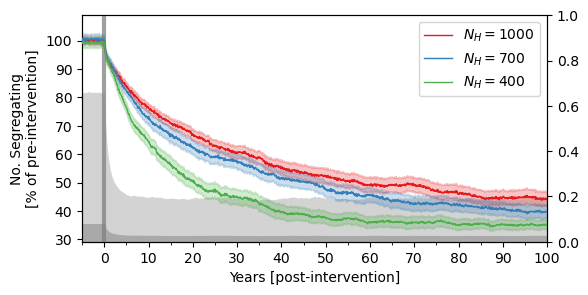

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

for expt in intv_names.keys():
    
    # Grab
    ot_mu = dt_mu[expt]
    ot_se = dt_se[expt]
    epoch_df = dt_epochs[expt]
    
    # Normalise time
    norm_t0 = epoch_df.loc["Crash", "t0"]
    t0 = ot_mu["t0"] - norm_t0
    
    # Plot genetic metric
    n_se = 1.96
    se_alpha = 0.25
    
    # Normalise
    norms = dt_norms[expt]
    mu = 100 * ot_mu[metric] / norms[metric]
    se = 100 * ot_se[metric] / norms[metric]
    
    # Plot genetics
    ax.plot(t0, mu, 
            color=intv_cols[expt], lw=1.0,
            zorder=3, label=intv_names[expt])
    ax.fill_between(x=t0,
                    y1=mu - se * n_se,
                    y2=mu + se * n_se,
                    color=intv_cols[expt], alpha=se_alpha,
                    zorder=2)
    
# Set limits, x-axis
time_limits = (-5*365, 100*365)
ax.set_xlim(time_limits)

# Set ticks, x-axis
days_per_year = 365
ax.xaxis.set_major_locator(plt.MultipleLocator(days_per_year * 10))
ax.xaxis.set_minor_locator(plt.MultipleLocator(days_per_year * 5))
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda v, i : int(v / days_per_year)))

ax.axvline(0, color='grey', alpha=0.75, linewidth=3, zorder=0)


# Labels
ax.set_xlabel("Years [post-intervention]")
ax.set_ylabel(genetic_names[metric] + "\n[% of pre-intervention]")


# Twin axis
ax.patch.set_visible(False)
axm = ax.twinx()
axm.set_zorder(ax.get_zorder() - 1)
axm.set_ylim((0, 1))

# Plot prevalence
axm.fill_between(x=t0, y1=0, y2=ot_mu["HX"], 
                color="lightgrey", linewidth=0.8, 
                label="Host All")
axm.fill_between(x=t0, y1=0, y2=ot_mu["VX"], 
                color="darkgrey", linewidth=0.8, 
                label="Vector All")

ax.legend()


if savefig:
    fig.savefig(os.path.join(output_dir, 
                             "%s_%s-%s_trajectory-%s.png" % (expt, focus, stat, metric)),
                bbox_inches="tight", pad_inches=0.5)
    fig.savefig(os.path.join(output_dir, 
                             "%s_%s-%s_trajectory-%s.pdf" % (expt, focus, stat, metric)),
                bbox_inches="tight", pad_inches=0.5)